# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Fengyu Cai"
student2 = "Junze Li"

### TODO LIST
<ul>
<li><input type="checkbox" disabled checked> ex1 </li>
<li><input type="checkbox" disabled checked> ex2 </li>
<li><input type="checkbox" disabled checked> ex3 </li>
<li><input type="checkbox" disabled checked> ex4 </li>
<li><input type="checkbox" disabled checked> ex5: the first layer 128 </li>
<li><input type="checkbox" disabled checked> ex6 </li>
<li><input type="checkbox" disabled checked> ex7: more sigmoid epochs </li>
</ul>

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

/home/lijunze0627/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

### Plotting

In [4]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [5]:
# load the data of MNIST and Fashion-MNIST
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

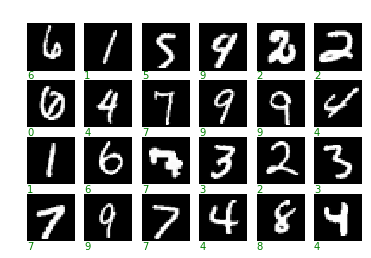

In [6]:
# plot some samples of mnist
plot_some_samples(x_train, y_train);

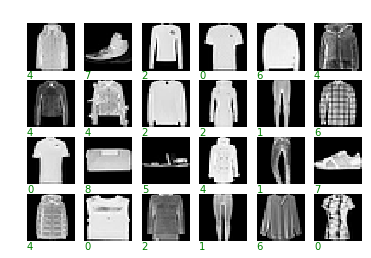

In [7]:
# plot some samples of fashion_mnist
plot_some_samples(x_fashion_train, y_fashion_train);

Answer to question 2:

The green number located at the left bottom cornor is the class label.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [9]:
x_train_conv = x_train.copy()
x_test_conv = x_test.copy()

x_fashion_train_conv = x_fashion_train.copy()
x_fashion_test_conv = x_fashion_test.copy()

In [10]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

### MNIST

In [11]:
# get the size of labels
label_size_mnist = np.shape(y_test)[1]
label_size_fashion = np.shape(y_fashion_test)[1]
print('The label size of MNIST is {}.'.format(label_size_mnist))
print('The label size of fashion-MNIST is {}.'.format(label_size_fashion))

The label size of MNIST is 10.
The label size of fashion-MNIST is 10.


In [15]:
# build up the model
model_no_hidden_layer = Sequential()
model_no_hidden_layer.add(Dense(label_size_mnist, activation='softmax', input_shape=(np.shape(x_train)[1], )))

In [13]:
# compile
model_no_hidden_layer.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# NN Structure
model_no_hidden_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
# early stop
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)

In [15]:
%%notify
history = model_no_hidden_layer.fit(x_train,
                                    y_train,
                                    batch_size=128,
                                    epochs=500,
                                    validation_data=(x_test, y_test),
                                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 21us/step - loss: 1.2569 - acc: 0.7050 - val_loss: 0.8031 - val_acc: 0.8337
Epoch 2/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.7108 - acc: 0.8422 - val_loss: 0.6044 - val_acc: 0.8602
Epoch 3/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.5848 - acc: 0.8607 - val_loss: 0.5244 - val_acc: 0.8716
Epoch 4/500
60000/60000 [==============================] - 1s 21us/step - loss: 0.5240 - acc: 0.8696 - val_loss: 0.4792 - val_acc: 0.8798
Epoch 5/500
60000/60000 [==============================] - 1s 22us/step - loss: 0.4869 - acc: 0.8760 - val_loss: 0.4498 - val_acc: 0.8844
Epoch 6/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.4613 - acc: 0.8806 - val_loss: 0.4286 - val_acc: 0.8883
Epoch 7/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.4423 - acc: 0.8839 - val_loss: 0.4129 - 

Epoch 118/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2824 - acc: 0.9215 - val_loss: 0.2795 - val_acc: 0.9208
Epoch 119/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2821 - acc: 0.9215 - val_loss: 0.2796 - val_acc: 0.9209
Epoch 120/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2819 - acc: 0.9213 - val_loss: 0.2793 - val_acc: 0.9207
Epoch 121/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2817 - acc: 0.9213 - val_loss: 0.2791 - val_acc: 0.9205
Epoch 122/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2815 - acc: 0.9215 - val_loss: 0.2791 - val_acc: 0.9213
Epoch 123/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2812 - acc: 0.9217 - val_loss: 0.2790 - val_acc: 0.9206
Epoch 124/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2811 - acc: 0.9218 - val_loss: 0.2787 - val_acc: 0.9206
Epoch 125/500
60000/

60000/60000 [==============================] - 1s 18us/step - loss: 0.2665 - acc: 0.9262 - val_loss: 0.2710 - val_acc: 0.9229
Epoch 235/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2665 - acc: 0.9265 - val_loss: 0.2709 - val_acc: 0.9229
Epoch 236/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2664 - acc: 0.9262 - val_loss: 0.2709 - val_acc: 0.9231
Epoch 237/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2663 - acc: 0.9263 - val_loss: 0.2709 - val_acc: 0.9232
Epoch 238/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2662 - acc: 0.9263 - val_loss: 0.2707 - val_acc: 0.9231
Epoch 239/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2661 - acc: 0.9263 - val_loss: 0.2705 - val_acc: 0.9232
Epoch 240/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2660 - acc: 0.9264 - val_loss: 0.2710 - val_acc: 0.9234
Epoch 241/500
60000/60000 [=======

60000/60000 [==============================] - 1s 17us/step - loss: 0.2589 - acc: 0.9285 - val_loss: 0.2676 - val_acc: 0.9242
Epoch 351/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2589 - acc: 0.9284 - val_loss: 0.2677 - val_acc: 0.9241
Epoch 352/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2588 - acc: 0.9284 - val_loss: 0.2676 - val_acc: 0.9239
Epoch 353/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2588 - acc: 0.9286 - val_loss: 0.2675 - val_acc: 0.9240
Epoch 354/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2587 - acc: 0.9286 - val_loss: 0.2676 - val_acc: 0.9242
Epoch 355/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2587 - acc: 0.9287 - val_loss: 0.2674 - val_acc: 0.9241
Epoch 356/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2586 - acc: 0.9286 - val_loss: 0.2676 - val_acc: 0.9242
Epoch 357/500
60000/60000 [=======

60000/60000 [==============================] - 1s 17us/step - loss: 0.2540 - acc: 0.9302 - val_loss: 0.2660 - val_acc: 0.9246
Epoch 467/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2540 - acc: 0.9303 - val_loss: 0.2662 - val_acc: 0.9248
Epoch 468/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2539 - acc: 0.9301 - val_loss: 0.2661 - val_acc: 0.9253
Epoch 469/500
60000/60000 [==============================] - 1s 19us/step - loss: 0.2539 - acc: 0.9304 - val_loss: 0.2662 - val_acc: 0.9244
Epoch 470/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2539 - acc: 0.9303 - val_loss: 0.2661 - val_acc: 0.9248
Epoch 471/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2539 - acc: 0.9302 - val_loss: 0.2661 - val_acc: 0.9251
Epoch 472/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2538 - acc: 0.9302 - val_loss: 0.2660 - val_acc: 0.9252
Epoch 473/500
60000/60000 [=======

<IPython.core.display.Javascript object>

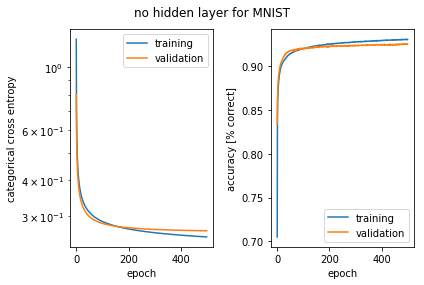

In [16]:
# plot the history
plot_history(history, 'no hidden layer for MNIST');

In [20]:
y_label_reverse = y_test.argmax(axis=1)

In [21]:
# do the prediction
y_hat = model_no_hidden_layer.predict(x_test).argmax(axis=1)

In [22]:
# find the different index
index_list = np.where(y_label_reverse != y_hat)[0]

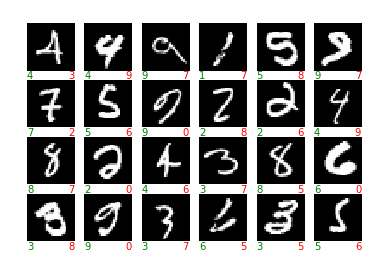

In [32]:
# wrong plot
plot_some_samples(x_test, y_label_reverse, y_hat, index_list);

### Fashion-MNIST

In [24]:
# build up the fashion model
model_no_hidden_layer_fashion = Sequential()
model_no_hidden_layer_fashion.add(Dense(label_size_fashion, activation='softmax', input_shape=(np.shape(x_fashion_train)[1], )))

In [25]:
# compile
model_no_hidden_layer_fashion.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model_no_hidden_layer_fashion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%notify
history_fashion = model_no_hidden_layer_fashion.fit(x_fashion_train,
                                                    y_fashion_train,
                                                    batch_size=128,
                                                    epochs=350,
                                                    validation_data=(x_fashion_test, y_fashion_test),
                                                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/350
60000/60000 [==============================] - 2s 37us/step - loss: 1.1576 - acc: 0.6448 - val_loss: 0.8732 - val_acc: 0.7146
Epoch 2/350
60000/60000 [==============================] - 2s 31us/step - loss: 0.7836 - acc: 0.7499 - val_loss: 0.7474 - val_acc: 0.7536
Epoch 3/350
60000/60000 [==============================] - 2s 28us/step - loss: 0.6966 - acc: 0.7779 - val_loss: 0.6897 - val_acc: 0.7722
Epoch 4/350
60000/60000 [==============================] - 2s 28us/step - loss: 0.6494 - acc: 0.7923 - val_loss: 0.6526 - val_acc: 0.7863
Epoch 5/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.6180 - acc: 0.8018 - val_loss: 0.6278 - val_acc: 0.7921
Epoch 6/350
60000/60000 [==============================] - 2s 28us/step - loss: 0.5956 - acc: 0.8075 - val_loss: 0.6092 - val_acc: 0.8004
Epoch 7/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.5782 - acc: 0.8130 - val_loss: 0.5956 - 

60000/60000 [==============================] - 2s 26us/step - loss: 0.4107 - acc: 0.8595 - val_loss: 0.4523 - val_acc: 0.8413
Epoch 118/350
60000/60000 [==============================] - 2s 26us/step - loss: 0.4103 - acc: 0.8597 - val_loss: 0.4521 - val_acc: 0.8418
Epoch 119/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.4101 - acc: 0.8602 - val_loss: 0.4520 - val_acc: 0.8418
Epoch 120/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.4099 - acc: 0.8606 - val_loss: 0.4519 - val_acc: 0.8423
Epoch 121/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.4097 - acc: 0.8602 - val_loss: 0.4514 - val_acc: 0.8420
Epoch 122/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.4094 - acc: 0.8598 - val_loss: 0.4513 - val_acc: 0.8428
Epoch 123/350
60000/60000 [==============================] - 2s 26us/step - loss: 0.4091 - acc: 0.8603 - val_loss: 0.4514 - val_acc: 0.8404
Epoch 124/350
60000/60000 [=======

60000/60000 [==============================] - 2s 27us/step - loss: 0.3919 - acc: 0.8657 - val_loss: 0.4407 - val_acc: 0.8442
Epoch 234/350
60000/60000 [==============================] - 2s 26us/step - loss: 0.3917 - acc: 0.8659 - val_loss: 0.4404 - val_acc: 0.8450
Epoch 235/350
60000/60000 [==============================] - 2s 26us/step - loss: 0.3917 - acc: 0.8659 - val_loss: 0.4403 - val_acc: 0.8450
Epoch 236/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.3914 - acc: 0.8658 - val_loss: 0.4410 - val_acc: 0.8449
Epoch 237/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.3914 - acc: 0.8660 - val_loss: 0.4410 - val_acc: 0.8439
Epoch 238/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.3913 - acc: 0.8658 - val_loss: 0.4403 - val_acc: 0.8448
Epoch 239/350
60000/60000 [==============================] - 2s 26us/step - loss: 0.3913 - acc: 0.8662 - val_loss: 0.4403 - val_acc: 0.8456
Epoch 240/350
60000/60000 [=======

60000/60000 [==============================] - 2s 27us/step - loss: 0.3826 - acc: 0.8682 - val_loss: 0.4366 - val_acc: 0.8453
Epoch 350/350
60000/60000 [==============================] - 2s 27us/step - loss: 0.3825 - acc: 0.8686 - val_loss: 0.4365 - val_acc: 0.8457


<IPython.core.display.Javascript object>

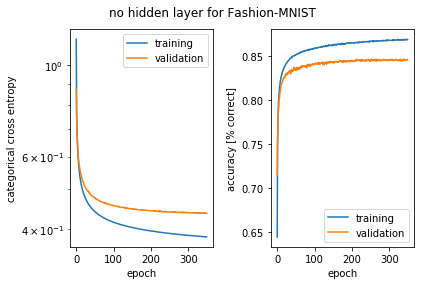

In [28]:
# plot the history
plot_history(history_fashion, 'no hidden layer for Fashion-MNIST');

In [29]:
y_label_fashion_reverse = y_fashion_test.argmax(axis=1)
# do the prediction
y_hat_fashion = model_no_hidden_layer_fashion.predict(x_fashion_test).argmax(axis=1)
# find the different index
index_list_fashion = np.where(y_label_fashion_reverse != y_hat_fashion)[0]

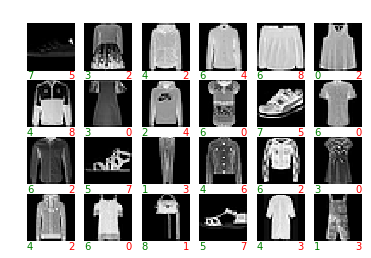

In [31]:
# wrong plot
plot_some_samples(x_fashion_test, y_label_fashion_reverse, y_hat_fashion, index_list_fashion);

Answer to question 8:

- green number: correct labels
- red number: wrong labels tagged by our model

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [12]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

##### Study on Learning Rate of SGD

In [44]:
model_one_layer = Sequential()
model_one_layer.add(Dense(128, activation='relu', input_shape=(np.shape(x_train)[1], )))
model_one_layer.add(Dense(label_size_mnist, activation='softmax'))

In [45]:
# display the structure of the network
model_one_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [46]:
learning_rate = np.logspace(-6, 6, num=5)

In [47]:
hist_sgd = {}
for lr in learning_rate:
    model_one_layer = Sequential()
    model_one_layer.add(Dense(128, activation='relu', input_shape=(np.shape(x_train)[1], )))
    model_one_layer.add(Dense(label_size_mnist, activation='softmax'))
    model_one_layer.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    # set batch size to speed up
    hist_sgd[lr] = model_one_layer.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)
    print('learning rate: {} accuracy: training acc: {} training loss: {}'.format(lr,
                                                                                  hist_sgd[lr].history['acc'][-1],
                                                                                  hist_sgd[lr].history['loss'][-1]))

learning rate: 1e-06 accuracy: training acc: 0.15071666666666667 training loss: 2.307708449172974
learning rate: 0.001 accuracy: training acc: 0.9024833333651224 training loss: 0.3507645761489868
learning rate: 1.0 accuracy: training acc: 0.09914999999602636 training loss: 14.519991182963054
learning rate: 1000.0 accuracy: training acc: 0.09930000000397364 training loss: 14.51757348836263
learning rate: 1000000.0 accuracy: training acc: 0.10218333333333333 training loss: 14.471099611409505


##### SGD vs Adam

In [48]:
model_one_layer = Sequential()
model_one_layer.add(Dense(128, activation='relu', input_shape=(np.shape(x_train)[1], )))
model_one_layer.add(Dense(label_size_mnist, activation='softmax'))
model_one_layer.compile(SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
histSGD = model_one_layer.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 59us/step - loss: 1.2120 - acc: 0.7106 - val_loss: 0.6469 - val_acc: 0.8533
Epoch 2/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.5563 - acc: 0.8639 - val_loss: 0.4573 - val_acc: 0.8861
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.4429 - acc: 0.8831 - val_loss: 0.3925 - val_acc: 0.8976
Epoch 4/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.3924 - acc: 0.8937 - val_loss: 0.3558 - val_acc: 0.9044
Epoch 5/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.3619 - acc: 0.9009 - val_loss: 0.3320 - val_acc: 0.9096
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.3402 - acc: 0.9058 - val_loss: 0.3149 - val_acc: 0.9139
Epoch 7/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.3235 - acc: 0.9103 - val_loss: 0.3009 - val_acc

In [49]:
model_one_layer = Sequential()
model_one_layer.add(Dense(128, activation='relu', input_shape=(np.shape(x_train)[1], )))
model_one_layer.add(Dense(label_size_mnist, activation='softmax'))
model_one_layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histAdam = model_one_layer.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.3651 - acc: 0.9013 - val_loss: 0.2094 - val_acc: 0.9370
Epoch 2/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1693 - acc: 0.9519 - val_loss: 0.1412 - val_acc: 0.9584
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1201 - acc: 0.9662 - val_loss: 0.1165 - val_acc: 0.9651
Epoch 4/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0933 - acc: 0.9729 - val_loss: 0.1064 - val_acc: 0.9639
Epoch 5/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0740 - acc: 0.9791 - val_loss: 0.0860 - val_acc: 0.9740
Epoch 6/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.0601 - acc: 0.9828 - val_loss: 0.0831 - val_acc: 0.9748
Epoch 7/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0513 - acc: 0.9855 - val_loss: 0.0850 - val_acc

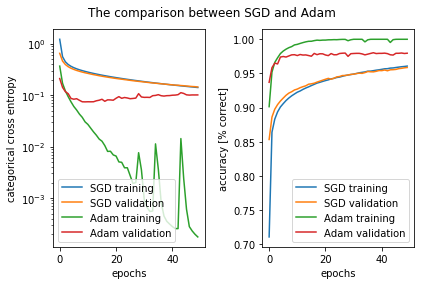

In [50]:
comparison_plot(histSGD, histAdam, 'SGD', 'Adam', 'The comparison between SGD and Adam');

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate of SGD is very large, the model will get a very low accuracy and can not converge to the optimal result.

B) When the learning rate of SGD is very small, the model will converge very slow and can not get a high accuracy in limited epochs.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: From the observation of the results above, we can find that the Adam begins to overfit after around epoch 13, when the validation loss no longer decreases, or even increases.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 
- In the loss curve, we can find that the training loss decreases to a smaller loss but the validation loss stays at a large loss, or even getting larger, which indicates the overfitting.
- In the accuracy curve, we can find that the training accuracy converges to a high accuracy but the validation accuracy only stays at a low accuracy, which also indicates the overfitting.
- Summary: there is a 'gap' in both accuracy and loss for training and validation.

In [47]:
# use adam to train the fashion
model_one_layer = Sequential()
model_one_layer.add(Dense(128, activation='relu', input_shape=(np.shape(x_train)[1], )))
model_one_layer.add(Dense(label_size_mnist, activation='softmax'))
model_one_layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_adam_fashion = model_one_layer.fit(x_fashion_train,
                                        y_fashion_train,
                                        batch_size=1024,
                                        epochs=200,                                
                                        validation_data=(x_fashion_test, y_fashion_test),
                                        verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 29us/step - loss: 0.8568 - acc: 0.7169 - val_loss: 0.5845 - val_acc: 0.8056
Epoch 2/200
60000/60000 [==============================] - 1s 13us/step - loss: 0.5146 - acc: 0.8254 - val_loss: 0.5059 - val_acc: 0.8259
Epoch 3/200
60000/60000 [==============================] - 1s 13us/step - loss: 0.4601 - acc: 0.8436 - val_loss: 0.4785 - val_acc: 0.8322
Epoch 4/200
60000/60000 [==============================] - 1s 13us/step - loss: 0.4313 - acc: 0.8525 - val_loss: 0.4511 - val_acc: 0.8428
Epoch 5/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.4115 - acc: 0.8588 - val_loss: 0.4499 - val_acc: 0.8415
Epoch 6/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.3954 - acc: 0.8642 - val_loss: 0.4400 - val_acc: 0.8473
Epoch 7/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.3821 - acc: 0.8677 - val_loss: 0.4143 - 

Epoch 118/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1184 - acc: 0.9605 - val_loss: 0.3702 - val_acc: 0.8856
Epoch 119/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1175 - acc: 0.9611 - val_loss: 0.3625 - val_acc: 0.8914
Epoch 120/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1165 - acc: 0.9609 - val_loss: 0.3699 - val_acc: 0.8875
Epoch 121/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1150 - acc: 0.9618 - val_loss: 0.3665 - val_acc: 0.8906
Epoch 122/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1157 - acc: 0.9611 - val_loss: 0.3683 - val_acc: 0.8883
Epoch 123/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1137 - acc: 0.9625 - val_loss: 0.3680 - val_acc: 0.8904
Epoch 124/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.1156 - acc: 0.9617 - val_loss: 0.3737 - val_acc: 0.8837
Epoch 125/200
60000/

In [112]:
with open('hist_one_layer_adam_fashion.pickle', 'wb') as w:
    pickle.dump(hist_adam_fashion, w)

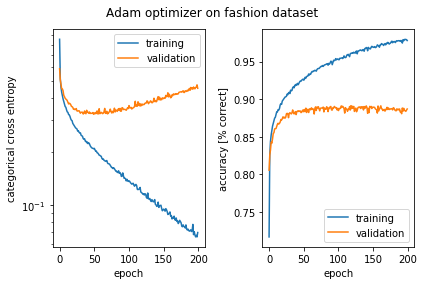

In [52]:
plot_history(hist_adam_fashion, 'Adam optimizer on fashion dataset');

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

### MNIST

In [94]:
# the size of hidden layer
noHidden = [10, 100, 300,500,750, 1000]

In [95]:
%%notify
hist_NN = {}
for no_hidden in noHidden:
    model_nn = Sequential()
    model_nn.add(Dense(no_hidden, activation='relu', input_shape=(np.shape(x_train)[1], )))
    model_nn.add(Dense(label_size_mnist, activation='softmax'))
    model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist_NN[no_hidden] = model_nn.fit(x_train,
                                  y_train,
                                  batch_size=128,
                                  epochs=350,
                                  callbacks=[early_stopping],
                                  validation_data=(x_test, y_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/350
60000/60000 [==============================] - 3s 48us/step - loss: 0.7987 - acc: 0.7610 - val_loss: 0.3804 - val_acc: 0.8951
Epoch 2/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.3484 - acc: 0.9021 - val_loss: 0.3058 - val_acc: 0.9140
Epoch 3/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.3030 - acc: 0.9144 - val_loss: 0.2882 - val_acc: 0.9190
Epoch 4/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.2832 - acc: 0.9206 - val_loss: 0.2753 - val_acc: 0.9218
Epoch 5/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.2711 - acc: 0.9242 - val_loss: 0.2710 - val_acc: 0.9246
Epoch 6/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.2632 - acc: 0.9264 - val_loss: 0.2643 - val_acc: 0.9252
Epoch 7/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.2562 - acc: 0.9285 - val_loss: 0.2619 - 

Epoch 118/350
60000/60000 [==============================] - 2s 32us/step - loss: 0.1363 - acc: 0.9603 - val_loss: 0.2138 - val_acc: 0.9440
Epoch 119/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.1365 - acc: 0.9602 - val_loss: 0.2103 - val_acc: 0.9453
Epoch 120/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.1356 - acc: 0.9604 - val_loss: 0.2132 - val_acc: 0.9443
Epoch 121/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.1359 - acc: 0.9603 - val_loss: 0.2154 - val_acc: 0.9440
Epoch 122/350
60000/60000 [==============================] - 2s 34us/step - loss: 0.1356 - acc: 0.9601 - val_loss: 0.2129 - val_acc: 0.9444
Epoch 123/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.1350 - acc: 0.9608 - val_loss: 0.2110 - val_acc: 0.9444
Epoch 124/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.1348 - acc: 0.9605 - val_loss: 0.2134 - val_acc: 0.9436
Epoch 125/350
60000/

Epoch 11/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 12/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0708 - val_acc: 0.9795
Epoch 13/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0079 - acc: 0.9984 - val_loss: 0.0757 - val_acc: 0.9798
Epoch 14/350
60000/60000 [==============================] - 4s 67us/step - loss: 0.0061 - acc: 0.9989 - val_loss: 0.0747 - val_acc: 0.9798
Epoch 15/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.0726 - val_acc: 0.9794
Epoch 16/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0741 - val_acc: 0.9795
Epoch 17/350
60000/60000 [==============================] - 4s 66us/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.0806 - val_acc: 0.9774
Epoch 18/350
60000/60000 [=

Epoch 9/350
60000/60000 [==============================] - 6s 99us/step - loss: 0.0097 - acc: 0.9977 - val_loss: 0.0634 - val_acc: 0.9816
Epoch 10/350
60000/60000 [==============================] - 6s 97us/step - loss: 0.0082 - acc: 0.9980 - val_loss: 0.0650 - val_acc: 0.9822
Epoch 11/350
60000/60000 [==============================] - 5s 91us/step - loss: 0.0074 - acc: 0.9980 - val_loss: 0.0750 - val_acc: 0.9804
Epoch 12/350
60000/60000 [==============================] - 6s 92us/step - loss: 0.0068 - acc: 0.9982 - val_loss: 0.0727 - val_acc: 0.9804
Epoch 13/350
60000/60000 [==============================] - 5s 92us/step - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0852 - val_acc: 0.9785
Epoch 14/350
60000/60000 [==============================] - 5s 91us/step - loss: 0.0060 - acc: 0.9983 - val_loss: 0.0777 - val_acc: 0.9804
Epoch 15/350
60000/60000 [==============================] - 5s 91us/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0655 - val_acc: 0.9830
Epoch 16/350
60000/60000 [==

<IPython.core.display.Javascript object>

In [96]:
with open('hist_NN_6.pickle', 'wb') as w:
    pickle.dump(hist_NN, w)

In [97]:
compareNN = {}
for k, v in hist_NN.items():
    compareNN[k] = [np.max(v.history['val_acc']), np.min(v.history['val_loss'])]

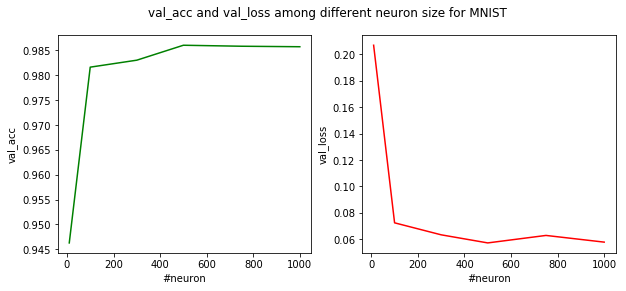

In [103]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('val_acc and val_loss among different neuron size for MNIST')
ax[0].plot(noHidden, [a[0] for a in compareNN.values()], 'g-')
ax[0].set_xlabel('#neuron')
ax[0].set_ylabel('val_acc')
ax[1].plot(noHidden, [a[1] for a in compareNN.values()], 'r-')
ax[1].set_xlabel('#neuron')
ax[1].set_ylabel('val_loss')
plt.show()

### Fashion-MNIST

In [99]:
%%notify
hist_NN_fashion = {}
for no_hidden in noHidden:
    model_nn = Sequential()
    model_nn.add(Dense(no_hidden, activation='relu', input_shape=(np.shape(x_fashion_train)[1], )))
    model_nn.add(Dense(label_size_mnist, activation='softmax'))
    model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist_NN_fashion[no_hidden] = model_nn.fit(x_fashion_train,
                                  y_fashion_train,
                                  batch_size=128,
                                  epochs=350,
                                  callbacks=[early_stopping],
                                  validation_data=(x_fashion_test, y_fashion_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/350
60000/60000 [==============================] - 3s 56us/step - loss: 0.8283 - acc: 0.7164 - val_loss: 0.5808 - val_acc: 0.8007
Epoch 2/350
60000/60000 [==============================] - 2s 32us/step - loss: 0.5167 - acc: 0.8247 - val_loss: 0.5171 - val_acc: 0.8240
Epoch 3/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.4677 - acc: 0.8396 - val_loss: 0.4909 - val_acc: 0.8293
Epoch 4/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.4451 - acc: 0.8453 - val_loss: 0.4751 - val_acc: 0.8329
Epoch 5/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.4297 - acc: 0.8517 - val_loss: 0.4610 - val_acc: 0.8376
Epoch 6/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.4198 - acc: 0.8528 - val_loss: 0.4537 - val_acc: 0.8403
Epoch 7/350
60000/60000 [==============================] - 2s 33us/step - loss: 0.4102 - acc: 0.8557 - val_loss: 0.4653 - 

60000/60000 [==============================] - 3s 46us/step - loss: 0.3451 - acc: 0.8772 - val_loss: 0.3795 - val_acc: 0.8646
Epoch 5/350
60000/60000 [==============================] - 3s 46us/step - loss: 0.3277 - acc: 0.8817 - val_loss: 0.3699 - val_acc: 0.8680
Epoch 6/350
60000/60000 [==============================] - 3s 45us/step - loss: 0.3105 - acc: 0.8880 - val_loss: 0.3578 - val_acc: 0.8716
Epoch 7/350
60000/60000 [==============================] - 3s 46us/step - loss: 0.2989 - acc: 0.8918 - val_loss: 0.3573 - val_acc: 0.8706
Epoch 8/350
60000/60000 [==============================] - 3s 46us/step - loss: 0.2882 - acc: 0.8948 - val_loss: 0.3547 - val_acc: 0.8706
Epoch 9/350
60000/60000 [==============================] - 3s 46us/step - loss: 0.2779 - acc: 0.8986 - val_loss: 0.3378 - val_acc: 0.8783
Epoch 10/350
60000/60000 [==============================] - 3s 45us/step - loss: 0.2711 - acc: 0.9009 - val_loss: 0.3540 - val_acc: 0.8744
Epoch 11/350
60000/60000 [===================

Epoch 63/350
60000/60000 [==============================] - 3s 51us/step - loss: 0.0996 - acc: 0.9645 - val_loss: 0.4293 - val_acc: 0.8874
Epoch 64/350
60000/60000 [==============================] - 3s 52us/step - loss: 0.0984 - acc: 0.9648 - val_loss: 0.4386 - val_acc: 0.8861
Epoch 65/350
60000/60000 [==============================] - 3s 52us/step - loss: 0.0970 - acc: 0.9653 - val_loss: 0.4416 - val_acc: 0.8852
Epoch 66/350
60000/60000 [==============================] - 3s 51us/step - loss: 0.0932 - acc: 0.9668 - val_loss: 0.4395 - val_acc: 0.8852
Epoch 67/350
60000/60000 [==============================] - 3s 51us/step - loss: 0.0921 - acc: 0.9669 - val_loss: 0.4601 - val_acc: 0.8837
Epoch 68/350
60000/60000 [==============================] - 3s 51us/step - loss: 0.0915 - acc: 0.9670 - val_loss: 0.4649 - val_acc: 0.8821
Epoch 69/350
60000/60000 [==============================] - 3s 51us/step - loss: 0.0903 - acc: 0.9671 - val_loss: 0.4678 - val_acc: 0.8826
Epoch 70/350
60000/60000 [=

60000/60000 [==============================] - 5s 82us/step - loss: 0.0980 - acc: 0.9634 - val_loss: 0.3961 - val_acc: 0.8943
Epoch 38/350
60000/60000 [==============================] - 5s 86us/step - loss: 0.0925 - acc: 0.9659 - val_loss: 0.4048 - val_acc: 0.8952
Epoch 39/350
60000/60000 [==============================] - 5s 85us/step - loss: 0.0876 - acc: 0.9676 - val_loss: 0.4110 - val_acc: 0.8951
Epoch 40/350
60000/60000 [==============================] - 5s 84us/step - loss: 0.0892 - acc: 0.9667 - val_loss: 0.4140 - val_acc: 0.8963
Epoch 41/350
60000/60000 [==============================] - 5s 82us/step - loss: 0.0855 - acc: 0.9682 - val_loss: 0.4240 - val_acc: 0.8884
Epoch 42/350
60000/60000 [==============================] - 5s 83us/step - loss: 0.0838 - acc: 0.9692 - val_loss: 0.4216 - val_acc: 0.8899
Epoch 43/350
60000/60000 [==============================] - 5s 84us/step - loss: 0.0811 - acc: 0.9703 - val_loss: 0.4439 - val_acc: 0.8914
Epoch 44/350
60000/60000 [==============

60000/60000 [==============================] - 6s 108us/step - loss: 0.1240 - acc: 0.9532 - val_loss: 0.3520 - val_acc: 0.8947
Epoch 27/350
60000/60000 [==============================] - 6s 105us/step - loss: 0.1203 - acc: 0.9550 - val_loss: 0.3695 - val_acc: 0.8888
Epoch 28/350
60000/60000 [==============================] - 6s 107us/step - loss: 0.1178 - acc: 0.9565 - val_loss: 0.3624 - val_acc: 0.8953
Epoch 29/350
60000/60000 [==============================] - 6s 108us/step - loss: 0.1131 - acc: 0.9585 - val_loss: 0.3740 - val_acc: 0.8920
Epoch 30/350
60000/60000 [==============================] - 6s 108us/step - loss: 0.1135 - acc: 0.9572 - val_loss: 0.3670 - val_acc: 0.8970
Epoch 31/350
60000/60000 [==============================] - 6s 108us/step - loss: 0.1085 - acc: 0.9596 - val_loss: 0.3659 - val_acc: 0.8949
Epoch 32/350
60000/60000 [==============================] - 6s 107us/step - loss: 0.1032 - acc: 0.9613 - val_loss: 0.3837 - val_acc: 0.8961
Epoch 33/350
60000/60000 [=======

<IPython.core.display.Javascript object>

In [100]:
with open('hist_NN_fashion_6.pickle', 'wb') as w:
    pickle.dump(hist_NN_fashion, w)

In [101]:
compareNN_fashion = {}
for k, v in hist_NN_fashion.items():
    compareNN_fashion[k] = [np.max(v.history['val_acc']), np.min(v.history['val_loss'])]

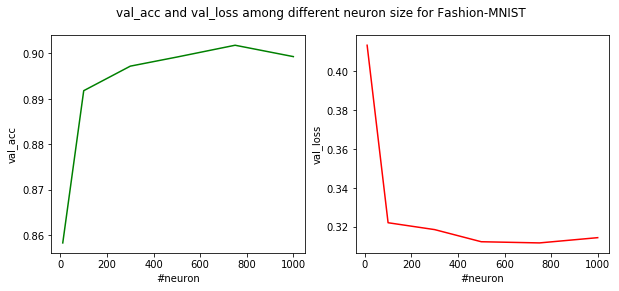

In [104]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('val_acc and val_loss among different neuron size for Fashion-MNIST')
ax[0].plot(noHidden, [a[0] for a in compareNN_fashion.values()], 'g-')
ax[0].set_xlabel('#neuron')
ax[0].set_ylabel('val_acc')
ax[1].plot(noHidden, [a[1] for a in compareNN_fashion.values()], 'r-')
ax[1].set_xlabel('#neuron')
ax[1].set_ylabel('val_loss')
plt.show()

Answer to question 2:

- Generally speaking, with the number of hidden neurons increasing, the validation accuracy increases and the validation loss decreases.
- Matching with the universal approximation theorem (Hanin showed that ReLU networks with width n+1 is sufficient to approximate any continuous convex function of n-dimensional input variables), in both datasets, we can find the model reaches the optimal when the number of hidden neurons is around the number of dimensions of input data (aka 28*28 + 1= 785).

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

### Observe overfitting on Fashion-MNIST

In [36]:
# two layers with each 50 neurons
model_overfit = Sequential()
model_overfit.add(Dense(128, activation='relu', input_shape=(np.shape(x_fashion_train)[1], )))
model_overfit.add(Dense(50, activation='relu'))
model_overfit.add(Dense(label_size_fashion, activation='softmax'))
model_overfit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_overfit = model_overfit.fit(x_fashion_train,
                                  y_fashion_train,
                                  batch_size=1024,
                                  epochs=200,
                                  validation_data=(x_fashion_test, y_fashion_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 29us/step - loss: 0.8908 - acc: 0.7068 - val_loss: 0.5545 - val_acc: 0.8079
Epoch 2/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.4896 - acc: 0.8315 - val_loss: 0.4870 - val_acc: 0.8317
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.4348 - acc: 0.8495 - val_loss: 0.4521 - val_acc: 0.8403
Epoch 4/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.4012 - acc: 0.8601 - val_loss: 0.4453 - val_acc: 0.8405
Epoch 5/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.3815 - acc: 0.8663 - val_loss: 0.4100 - val_acc: 0.8555
Epoch 6/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.3640 - acc: 0.8716 - val_loss: 0.3991 - val_acc: 0.8600
Epoch 7/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.3469 - acc: 0.8779 - val_loss: 0.3870 - 

Epoch 118/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.0625 - acc: 0.9796 - val_loss: 0.5226 - val_acc: 0.8836
Epoch 119/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.0691 - acc: 0.9759 - val_loss: 0.5153 - val_acc: 0.8844
Epoch 120/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.0670 - acc: 0.9773 - val_loss: 0.5469 - val_acc: 0.8730
Epoch 121/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.0638 - acc: 0.9779 - val_loss: 0.5205 - val_acc: 0.8832
Epoch 122/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.0572 - acc: 0.9818 - val_loss: 0.5227 - val_acc: 0.8816
Epoch 123/200
60000/60000 [==============================] - 1s 15us/step - loss: 0.0564 - acc: 0.9815 - val_loss: 0.5345 - val_acc: 0.8813
Epoch 124/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.0629 - acc: 0.9786 - val_loss: 0.5308 - val_acc: 0.8849
Epoch 125/200
60000/

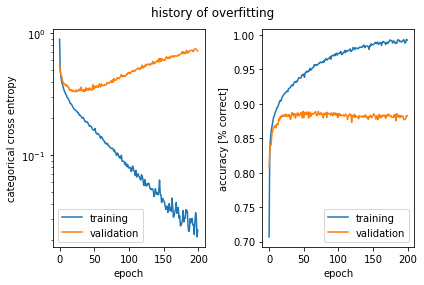

In [37]:
plot_history(hist_overfit, title='history of overfitting');

### Improve the performance
##### Experiment with dropout layer and regularization

l2-regularization parameter: 10<sup>-3</sup>, dropout rate: 0.1.

In [23]:
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

In [38]:
%%notify
model_nobn_drop = Sequential()
model_nobn_drop.add(Dense(128, 
                        activation='relu',
                        input_shape=(np.shape(x_fashion_train)[1], ),
                        kernel_regularizer=l2(1e-3),
                        bias_regularizer=l2(1e-3)))

model_nobn_drop.add(Dropout(rate=0.1))

model_nobn_drop.add(Dense(50,
                        activation='relu',
                       kernel_regularizer=l2(1e-3),
                       bias_regularizer=l2(1e-3)))

model_nobn_drop.add(Dropout(rate=0.1))

model_nobn_drop.add(Dense(label_size_fashion, activation='softmax'))
model_nobn_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_nobn_drop = model_nobn_drop.fit(x_fashion_train,
                                  y_fashion_train,
                                  batch_size=1024,
                                  epochs=200,
                                  validation_data=(x_fashion_test, y_fashion_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 39us/step - loss: 1.2653 - acc: 0.6550 - val_loss: 0.8437 - val_acc: 0.7902
Epoch 2/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.8049 - acc: 0.8016 - val_loss: 0.7129 - val_acc: 0.8269
Epoch 3/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.6995 - acc: 0.8282 - val_loss: 0.6493 - val_acc: 0.8416
Epoch 4/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.6349 - acc: 0.8425 - val_loss: 0.6094 - val_acc: 0.8472
Epoch 5/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.5935 - acc: 0.8501 - val_loss: 0.5788 - val_acc: 0.8520
Epoch 6/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.5656 - acc: 0.8563 - val_loss: 0.5580 - val_acc: 0.8555
Epoch 7/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.5429 - acc: 0.8597 - val_loss: 0.5410 - 

Epoch 118/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.3003 - acc: 0.9185 - val_loss: 0.3809 - val_acc: 0.8906
Epoch 119/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.3007 - acc: 0.9195 - val_loss: 0.3917 - val_acc: 0.8850
Epoch 120/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2979 - acc: 0.9202 - val_loss: 0.3841 - val_acc: 0.8907
Epoch 121/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2963 - acc: 0.9206 - val_loss: 0.3866 - val_acc: 0.8905
Epoch 122/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2972 - acc: 0.9210 - val_loss: 0.3808 - val_acc: 0.8905
Epoch 123/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2982 - acc: 0.9201 - val_loss: 0.3900 - val_acc: 0.8888
Epoch 124/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2941 - acc: 0.9218 - val_loss: 0.3882 - val_acc: 0.8891
Epoch 125/200
60000/

<IPython.core.display.Javascript object>

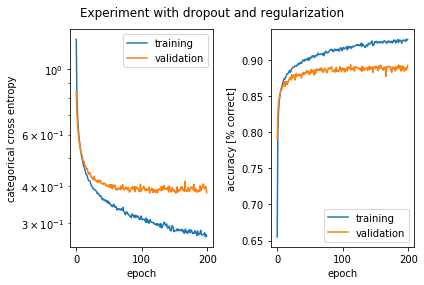

In [39]:
plot_history(hist_nobn_drop, title='Experiment with dropout and regularization');

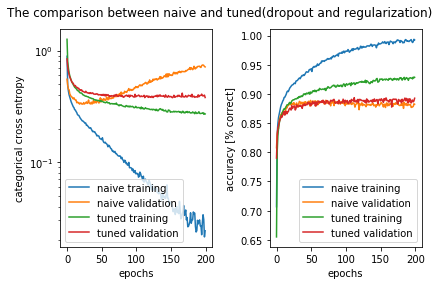

In [40]:
comparison_plot(hist_overfit, hist_nobn_drop, 'naive', 'tuned', 'The comparison between naive and tuned(dropout and regularization)');

##### Experiment with batch-normalization layer and regularization

l2-regularization parameter: 10<sup>-3</sup>, batch-normalization layer with default value.

In [41]:
%%notify
model_bn_nodrop = Sequential()
model_bn_nodrop.add(Dense(128, 
                        activation='relu',
                        input_shape=(np.shape(x_fashion_train)[1], ),
                        kernel_regularizer=l2(1e-3),
                        bias_regularizer=l2(1e-3)))

model_bn_nodrop.add(BatchNormalization())

model_bn_nodrop.add(Dense(50,
                        activation='relu',
                       kernel_regularizer=l2(1e-3),
                       bias_regularizer=l2(1e-3)))

model_bn_nodrop.add(BatchNormalization())

model_bn_nodrop.add(Dense(label_size_fashion, activation='softmax'))
model_bn_nodrop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_bn_nodrop = model_bn_nodrop.fit(x_fashion_train,
                                  y_fashion_train,
                                  batch_size=1024,
                                  epochs=200,
                                  validation_data=(x_fashion_test, y_fashion_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 55us/step - loss: 0.9905 - acc: 0.7683 - val_loss: 0.7659 - val_acc: 0.8330
Epoch 2/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.6664 - acc: 0.8562 - val_loss: 0.6910 - val_acc: 0.8400
Epoch 3/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.5852 - acc: 0.8735 - val_loss: 0.6340 - val_acc: 0.8506
Epoch 4/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.5309 - acc: 0.8831 - val_loss: 0.5927 - val_acc: 0.8593
Epoch 5/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.4882 - acc: 0.8898 - val_loss: 0.5846 - val_acc: 0.8578
Epoch 6/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.4548 - acc: 0.8954 - val_loss: 0.5492 - val_acc: 0.8614
Epoch 7/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.4264 - acc: 0.9001 - val_loss: 0.5193 - 

Epoch 118/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.1565 - acc: 0.9645 - val_loss: 0.6777 - val_acc: 0.8541
Epoch 119/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.1593 - acc: 0.9637 - val_loss: 0.6216 - val_acc: 0.8651
Epoch 120/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.1534 - acc: 0.9653 - val_loss: 0.6558 - val_acc: 0.8584
Epoch 121/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.1488 - acc: 0.9677 - val_loss: 0.5916 - val_acc: 0.8728
Epoch 122/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.1499 - acc: 0.9666 - val_loss: 0.7082 - val_acc: 0.8482
Epoch 123/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.1583 - acc: 0.9629 - val_loss: 0.7197 - val_acc: 0.8414
Epoch 124/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.1467 - acc: 0.9679 - val_loss: 0.7492 - val_acc: 0.8452
Epoch 125/200
60000/

<IPython.core.display.Javascript object>

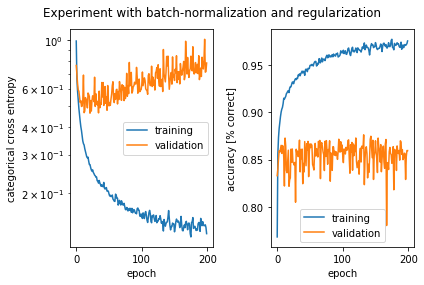

In [42]:
plot_history(hist_bn_nodrop, title='Experiment with batch-normalization and regularization');

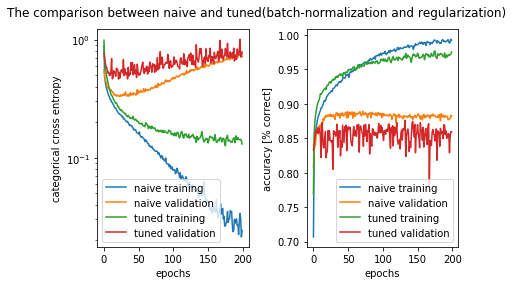

In [43]:
comparison_plot(hist_overfit, hist_bn_nodrop, 'naive', 'tuned', 'The comparison between naive and tuned(batch-normalization and regularization)');

##### Experiment with only regularization

l2-regularization parameter: 10<sup>-3</sup>

In [44]:
%%notify
model_nobn_nodrop = Sequential()
model_nobn_nodrop.add(Dense(128, 
                        activation='relu',
                        input_shape=(np.shape(x_fashion_train)[1], ),
                        kernel_regularizer=l2(1e-3),
                        bias_regularizer=l2(1e-3)))

model_nobn_nodrop.add(Dense(50,
                        activation='relu',
                       kernel_regularizer=l2(1e-3),
                       bias_regularizer=l2(1e-3)))

model_nobn_nodrop.add(Dense(label_size_fashion, activation='softmax'))
model_nobn_nodrop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_nobn_nodrop = model_nobn_nodrop.fit(x_fashion_train,
                                  y_fashion_train,
                                  batch_size=1024,
                                  epochs=200,
                                  validation_data=(x_fashion_test, y_fashion_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 37us/step - loss: 1.1843 - acc: 0.7044 - val_loss: 0.8093 - val_acc: 0.8038
Epoch 2/200
60000/60000 [==============================] - 1s 17us/step - loss: 0.7244 - acc: 0.8299 - val_loss: 0.7123 - val_acc: 0.8230
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.6519 - acc: 0.8438 - val_loss: 0.6502 - val_acc: 0.8383
Epoch 4/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.6036 - acc: 0.8535 - val_loss: 0.6173 - val_acc: 0.8447
Epoch 5/200
60000/60000 [==============================] - 1s 17us/step - loss: 0.5755 - acc: 0.8590 - val_loss: 0.5934 - val_acc: 0.8455
Epoch 6/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.5483 - acc: 0.8655 - val_loss: 0.5881 - val_acc: 0.8433
Epoch 7/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.5306 - acc: 0.8681 - val_loss: 0.5644 - 

Epoch 118/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2842 - acc: 0.9279 - val_loss: 0.3960 - val_acc: 0.8869
Epoch 119/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2807 - acc: 0.9303 - val_loss: 0.3942 - val_acc: 0.8873
Epoch 120/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2897 - acc: 0.9253 - val_loss: 0.3976 - val_acc: 0.8867
Epoch 121/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2869 - acc: 0.9271 - val_loss: 0.3905 - val_acc: 0.8910
Epoch 122/200
60000/60000 [==============================] - 1s 17us/step - loss: 0.2815 - acc: 0.9286 - val_loss: 0.4031 - val_acc: 0.8829
Epoch 123/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2841 - acc: 0.9287 - val_loss: 0.3946 - val_acc: 0.8884
Epoch 124/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.2890 - acc: 0.9254 - val_loss: 0.4013 - val_acc: 0.8875
Epoch 125/200
60000/

<IPython.core.display.Javascript object>

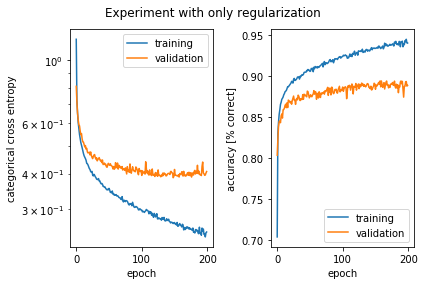

In [45]:
plot_history(hist_nobn_nodrop, title='Experiment with only regularization');

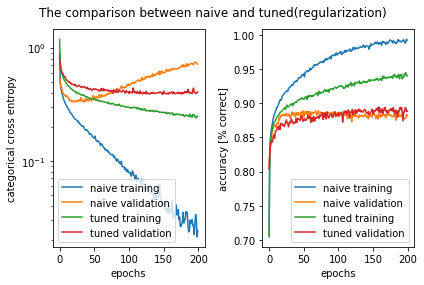

In [46]:
comparison_plot(hist_overfit, hist_nobn_nodrop, 'naive', 'tuned', 'The comparison between naive and tuned(regularization)');

Based on the experiments of different tricks, we can find that the neural network using regularization and dropout layer performs best. So we compare this model with the one layer model in the previous part.

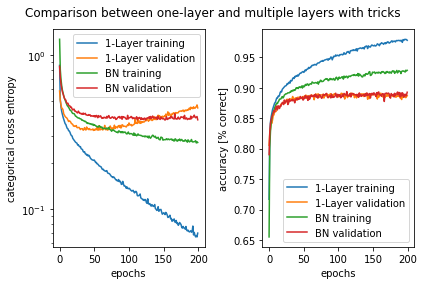

In [50]:
comparison_plot(hist_adam_fashion, hist_nobn_drop, '1-Layer', 'BN', 'Comparison between one-layer and multiple layers with tricks');

Answer to question 2 (comments):

- After adding batch_normalization layer and dropout layer, the overfitting effect decreases obviously and the accuracy increases slightly.
- The model with batchnorm, dropout and regularization can perform as well as the one-layer network, and the performance gap between training and validation is smaller than one-layer network.

### The same network structure trained on the MNIST

In [24]:
model_drop_mnist = Sequential()
model_drop_mnist.add(Dense(128, 
                        activation='relu',
                        input_shape=(np.shape(x_fashion_train)[1], ),
                        kernel_regularizer=l2(1e-3),
                        bias_regularizer=l2(1e-3)))


model_drop_mnist.add(Dropout(rate=0.1))

model_drop_mnist.add(Dense(50,
                        activation='relu',
                       kernel_regularizer=l2(1e-3),
                       bias_regularizer=l2(1e-3)))

model_drop_mnist.add(Dropout(rate=0.1))

model_drop_mnist.add(Dense(label_size_fashion, activation='softmax'))
model_drop_mnist.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_drop_mnist = model_drop_mnist.fit(x_train,
                                  y_train,
                                  batch_size=1024,
                                  epochs=200,
                                  validation_data=(x_test, y_test),
                                  verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 39us/step - loss: 1.1900 - acc: 0.7152 - val_loss: 0.5390 - val_acc: 0.9050
Epoch 2/200
60000/60000 [==============================] - 1s 21us/step - loss: 0.5486 - acc: 0.8947 - val_loss: 0.4214 - val_acc: 0.9292
Epoch 3/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.4511 - acc: 0.9190 - val_loss: 0.3645 - val_acc: 0.9406
Epoch 4/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.3926 - acc: 0.9321 - val_loss: 0.3247 - val_acc: 0.9506
Epoch 5/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.3534 - acc: 0.9412 - val_loss: 0.2987 - val_acc: 0.9556
Epoch 6/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.3231 - acc: 0.9482 - val_loss: 0.2738 - val_acc: 0.9600
Epoch 7/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.3001 - acc: 0.9520 - val_loss: 0.2584 - 

Epoch 118/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.0930 - acc: 0.9887 - val_loss: 0.1110 - val_acc: 0.9815
Epoch 119/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.0929 - acc: 0.9889 - val_loss: 0.1093 - val_acc: 0.9821
Epoch 120/200
60000/60000 [==============================] - 1s 20us/step - loss: 0.0914 - acc: 0.9898 - val_loss: 0.1087 - val_acc: 0.9828
Epoch 121/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.0928 - acc: 0.9886 - val_loss: 0.1119 - val_acc: 0.9821
Epoch 122/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.0925 - acc: 0.9888 - val_loss: 0.1072 - val_acc: 0.9831
Epoch 123/200
60000/60000 [==============================] - 1s 17us/step - loss: 0.0921 - acc: 0.9887 - val_loss: 0.1079 - val_acc: 0.9837
Epoch 124/200
60000/60000 [==============================] - 1s 18us/step - loss: 0.0929 - acc: 0.9888 - val_loss: 0.1058 - val_acc: 0.9840
Epoch 125/200
60000/

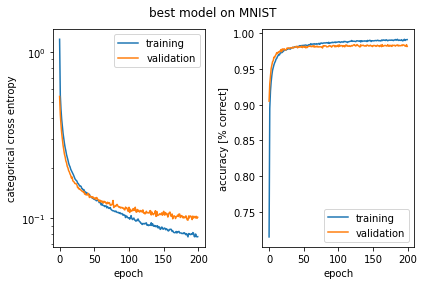

In [25]:
plot_history(hist_drop_mnist, title='best model on MNIST');

On MNIST, the neural network with deeper tricky layers performs better than just one layer. 

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

### MNIST

In [15]:
xd, yd, zd = np.shape(x_train_conv)
xd_test, yd_test, zd_test = np.shape(x_test_conv)
x_train_conv = np.reshape(x_train_conv, (xd, yd, zd, 1))
x_test_conv = np.reshape(x_test_conv, (xd_test, yd_test, zd_test, 1))

In [38]:
model_conv = Sequential()
model_conv.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))

model_conv.add(Conv2D(32, (3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
# model_conv.add(Dropout(0.2))
model_conv.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_conv.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(64, (3, 3), activation='relu'))
model_conv.add(Conv2D(64, (3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.3))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dense(label_size_mnist, activation='softmax'))

In [15]:
%%notify
model_conv.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

hist_conv = model_conv.fit(x_train_conv, y_train,
                          batch_size=128,
                          epochs=40,
                          verbose=1,
                          validation_data=(x_test_conv, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 159s 3ms/step - loss: 0.3368 - acc: 0.8991 - val_loss: 0.0567 - val_acc: 0.9809
Epoch 2/40
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0781 - acc: 0.9773 - val_loss: 0.0274 - val_acc: 0.9915
Epoch 3/40
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0520 - acc: 0.9847 - val_loss: 0.0302 - val_acc: 0.9902
Epoch 4/40
60000/60000 [==============================] - 158s 3ms/step - loss: 0.0429 - acc: 0.9870 - val_loss: 0.0401 - val_acc: 0.9887
Epoch 5/40
60000/60000 [==============================] - 145s 2ms/step - loss: 0.0350 - acc: 0.9896 - val_loss: 0.0328 - val_acc: 0.9900
Epoch 6/40
60000/60000 [==============================] - 143s 2ms/step - loss: 0.0291 - acc: 0.9912 - val_loss: 0.0261 - val_acc: 0.9930
Epoch 7/40
60000/60000 [==============================] - 145s 2ms/step - loss: 0.0249 - acc: 0.9925 - val_loss: 0.0295 - 

<IPython.core.display.Javascript object>

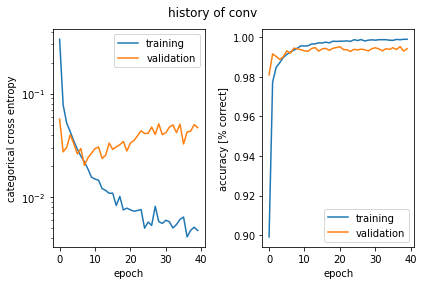

In [17]:
plot_history(hist_conv, title='history of conv');

### Fashion-MNIST

In [45]:
%%notify
model_conv.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

hist_conv_fashion = model_conv.fit(x_fashion_train_conv, y_fashion_train,
                          batch_size=128,
                          epochs=40,
                          verbose=1,
                          validation_data=(x_fashion_test_conv, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 161s 3ms/step - loss: 0.5013 - acc: 0.8187 - val_loss: 0.3870 - val_acc: 0.8550
Epoch 2/40
60000/60000 [==============================] - 154s 3ms/step - loss: 0.3705 - acc: 0.8660 - val_loss: 0.3278 - val_acc: 0.8780
Epoch 3/40
60000/60000 [==============================] - 166s 3ms/step - loss: 0.3146 - acc: 0.8857 - val_loss: 0.3057 - val_acc: 0.8873
Epoch 4/40
60000/60000 [==============================] - 166s 3ms/step - loss: 0.2834 - acc: 0.8959 - val_loss: 0.2819 - val_acc: 0.8980
Epoch 5/40
60000/60000 [==============================] - 162s 3ms/step - loss: 0.2565 - acc: 0.9069 - val_loss: 0.2696 - val_acc: 0.9008
Epoch 6/40
60000/60000 [==============================] - 165s 3ms/step - loss: 0.2399 - acc: 0.9123 - val_loss: 0.2684 - val_acc: 0.9047
Epoch 7/40
60000/60000 [==============================] - 171s 3ms/step - loss: 0.2268 - acc: 0.9163 - val_loss: 0.2634 - 

<IPython.core.display.Javascript object>

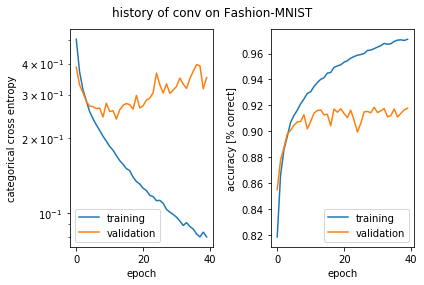

In [46]:
plot_history(hist_conv_fashion, title='history of conv on Fashion-MNIST');

Answer to question 3:

- The accuracy of the CNN is higher than all the network structure before (the optimal full-connected network).
- For reaching the same accuracy, CNN costs less time and fewer epoches than full-connected networks, while each epoch in CNN will take longer time than others.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

### using the sigmoid activation function on MNIST

In [57]:
model_sigmoid = Sequential()
model_sigmoid.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=(28,28,1),
                        padding='same'))

model_sigmoid.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid.add(MaxPooling2D(pool_size=(2, 2)))
model_sigmoid.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.2))
model_sigmoid.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_sigmoid.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_sigmoid.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.3))
model_sigmoid.add(Flatten())
model_sigmoid.add(Dense(256, activation='sigmoid'))
model_sigmoid.add(Dense(label_size_mnist, activation='softmax'))

In [58]:
model_sigmoid.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

hist_sigmoid = model_sigmoid.fit(x_train_conv, y_train,
                              batch_size=1024,
                              epochs=40,
                              verbose=1,
                              validation_data=(x_test_conv, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 76s 1ms/step - loss: 2.3113 - acc: 0.1062 - val_loss: 2.3065 - val_acc: 0.0980
Epoch 2/40
60000/60000 [==============================] - 72s 1ms/step - loss: 2.3052 - acc: 0.1048 - val_loss: 2.3064 - val_acc: 0.1010
Epoch 3/40
60000/60000 [==============================] - 72s 1ms/step - loss: 2.3059 - acc: 0.1039 - val_loss: 2.3103 - val_acc: 0.1135
Epoch 4/40
60000/60000 [==============================] - 72s 1ms/step - loss: 2.3071 - acc: 0.1032 - val_loss: 2.3080 - val_acc: 0.1135
Epoch 5/40
60000/60000 [==============================] - 72s 1ms/step - loss: 2.3061 - acc: 0.1038 - val_loss: 2.3095 - val_acc: 0.1010
Epoch 6/40
60000/60000 [==============================] - 71s 1ms/step - loss: 2.3066 - acc: 0.1021 - val_loss: 2.3137 - val_acc: 0.1135
Epoch 7/40
60000/60000 [==============================] - 71s 1ms/step - loss: 2.3065 - acc: 0.1017 - val_loss: 2.3072 - val_acc

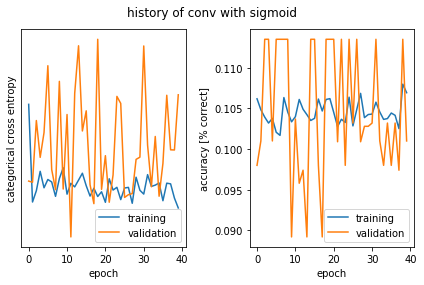

In [59]:
plot_history(hist_sigmoid, title='history of conv with sigmoid');

From the training record, we can find that the validation loss no longer decreases which indicates the gradient vanish in training when the activation function is the sigmoid function.

### using the sigmoid activation function with fewer convolutional layers on MNIST

In [19]:
model_sigmoid_central = Sequential()
model_sigmoid_central.add(Conv2D(32, kernel_size=(3, 3),
                             activation='sigmoid',
                             input_shape=(28,28,1),
                             padding='same',
                                kernel_initializer='glorot_normal'))

model_sigmoid_central.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same',kernel_initializer='glorot_normal'))
model_sigmoid_central.add(MaxPooling2D(pool_size=(2, 2)))
model_sigmoid_central.add(Conv2D(64, (3, 3), activation='sigmoid',padding='same',kernel_initializer='glorot_normal'))
# model_sigmoid_central.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same',kernel_initializer='glorot_normal'))
model_sigmoid_central.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.2))
# model_sigmoid_central.add(Conv2D(64, (3, 3), activation='sigmoid',kernel_initializer='glorot_normal'))
# model_sigmoid_central.add(Conv2D(64, (3, 3), activation='sigmoid',kernel_initializer='glorot_normal'))
# model_sigmoid_central.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.3))
model_sigmoid_central.add(Flatten())
model_sigmoid_central.add(Dense(256, activation='sigmoid', kernel_initializer='glorot_normal'))
model_sigmoid_central.add(Dense(label_size_mnist, activation='softmax'))

In [20]:
model_sigmoid_central.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

hist_sigmoid = model_sigmoid_central.fit(x_train_conv, y_train,
                              batch_size=1024,
                              epochs=40,
                              verbose=1,
                              validation_data=(x_test_conv, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 79s 1ms/step - loss: 2.3551 - acc: 0.1111 - val_loss: 2.2883 - val_acc: 0.1870
Epoch 2/40
60000/60000 [==============================] - 77s 1ms/step - loss: 1.9695 - acc: 0.3178 - val_loss: 1.3591 - val_acc: 0.5468
Epoch 3/40
60000/60000 [==============================] - 76s 1ms/step - loss: 0.8760 - acc: 0.7195 - val_loss: 0.6706 - val_acc: 0.7724
Epoch 4/40
60000/60000 [==============================] - 76s 1ms/step - loss: 0.5019 - acc: 0.8368 - val_loss: 0.4166 - val_acc: 0.8508
Epoch 5/40
60000/60000 [==============================] - 75s 1ms/step - loss: 0.3601 - acc: 0.8908 - val_loss: 0.2929 - val_acc: 0.9131
Epoch 6/40
60000/60000 [==============================] - 75s 1ms/step - loss: 0.2812 - acc: 0.9181 - val_loss: 0.2350 - val_acc: 0.9344
Epoch 7/40
60000/60000 [==============================] - 76s 1ms/step - loss: 0.2341 - acc: 0.9317 - val_loss: 0.2049 - val_acc

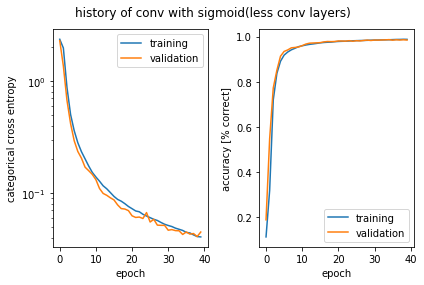

In [21]:
plot_history(hist_sigmoid, title='history of conv with sigmoid(less conv layers)');

We find that for the learning curve of CNN with fewer convolutional layers, the gradient vanish is less likely to happen and CNN performs better, verifying that gradient vanish is more likely to happen when the structure goes deeper.

### using the sigmoid activation function with batch normalization on MNIST

In [23]:
model_sigmoid_bn = Sequential()
model_sigmoid_bn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=(28,28,1),
                        padding='same'))

model_sigmoid_bn.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid_bn.add(BatchNormalization())
model_sigmoid_bn.add(MaxPooling2D(pool_size=(2, 2)))
model_sigmoid_bn.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid_bn.add(Conv2D(32, (3, 3), activation='sigmoid',padding='same'))
model_sigmoid_bn.add(BatchNormalization())
model_sigmoid_bn.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.2))
model_sigmoid_bn.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_sigmoid_bn.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_sigmoid_bn.add(BatchNormalization())
model_sigmoid_bn.add(MaxPooling2D(pool_size=(2, 2)))
# model_sigmoid.add(Dropout(0.3))
model_sigmoid_bn.add(Flatten())
model_sigmoid_bn.add(Dense(256, activation='sigmoid'))
model_sigmoid_bn.add(Dense(label_size_mnist, activation='softmax'))

In [24]:
%%notify
model_sigmoid_bn.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

hist_sigmoid_bn = model_sigmoid_bn.fit(x_train_conv, y_train,
                                batch_size=128,
                                epochs=40,
                                verbose=1,
                                validation_data=(x_test_conv, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 274s 5ms/step - loss: 0.1595 - acc: 0.9645 - val_loss: 0.0336 - val_acc: 0.9884
Epoch 2/40
60000/60000 [==============================] - 274s 5ms/step - loss: 0.0324 - acc: 0.9898 - val_loss: 0.0376 - val_acc: 0.9887
Epoch 3/40
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0220 - acc: 0.9932 - val_loss: 0.1004 - val_acc: 0.9701
Epoch 4/40
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0165 - acc: 0.9949 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 5/40
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0112 - acc: 0.9967 - val_loss: 0.0297 - val_acc: 0.9909
Epoch 6/40
60000/60000 [==============================] - 273s 5ms/step - loss: 0.0082 - acc: 0.9974 - val_loss: 0.0275 - val_acc: 0.9915
Epoch 7/40
60000/60000 [==============================] - 276s 5ms/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0894 - 

<IPython.core.display.Javascript object>

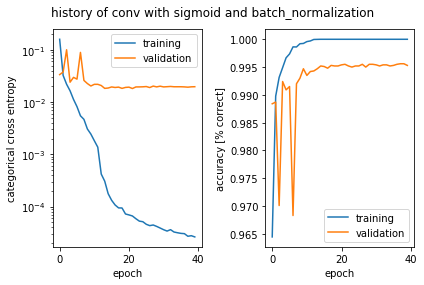

In [25]:
plot_history(hist_sigmoid_bn, title='history of conv with sigmoid and batch_normalization');

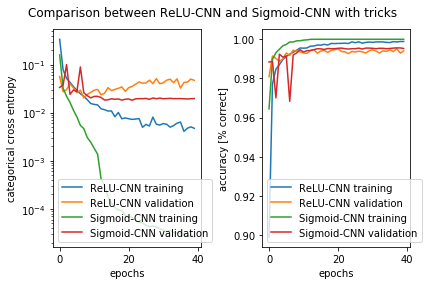

In [28]:
comparison_plot(hist_conv, hist_sigmoid_bn, 'ReLU-CNN', 'Sigmoid-CNN', 'Comparison between ReLU-CNN and Sigmoid-CNN with tricks');

Answer to question 1:

The train loss and validation loss do not decrease which is cause by gradient vanish when we use sigmoid activation function.

Answer to question 2:

The train loss and validation loss can decrease to a low value and the performance is similar to the ReLU-CNN performance.  

---